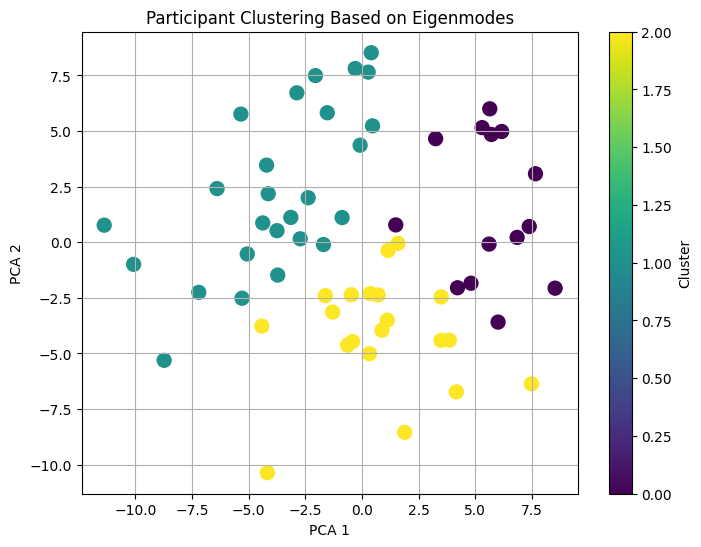

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Step 1: Simulate eigenmodes per participant to test before modes from real data is extracted---

def simulate_eeg_modes(n_participants=60, n_modes=25, n_channels=32):
    data = []
    for _ in range(n_participants):
        modes = []
        for _ in range(n_modes):
            eigval = np.random.rand() + 1j * np.random.rand()
            eigvec = np.random.rand(n_channels) + 1j * np.random.rand(n_channels)
            modes.append((eigval, eigvec))
        data.append(modes)
    return data

# --- Step 2: Extract top-N mode features per participant ---

def extract_participant_features(mode_data, top_n_modes=10):
    all_participant_features = []
    for modes in mode_data:
        # Sort modes by eigenvector norm (energy)
        sorted_modes = sorted(modes, key=lambda m: np.linalg.norm(m[1]), reverse=True)[:top_n_modes]
        mode_features = []
        for eigval, eigvec in sorted_modes:
            freq = np.abs(np.imag(eigval))
            damping = -np.real(eigval)
            energy = np.linalg.norm(eigvec)
            spatial = np.concatenate([np.real(eigvec), np.imag(eigvec)])  # shape (2 * n_channels,)
            features = np.concatenate([[freq, damping, energy], spatial])
            mode_features.append(features)
        # Flatten all selected mode features into one long vector
        participant_vector = np.concatenate(mode_features)
        all_participant_features.append(participant_vector)
    return np.array(all_participant_features)

# --- Step 3: Normalize, reduce dimensions, cluster participants ---

def cluster_and_plot(features, n_clusters=3):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features_pca)

    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis', s=100)
    plt.title("Participant Clustering Based on Eigenmodes")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(label="Cluster")
    plt.grid(True)
    plt.show()

    return labels, features_pca

# --- Run the full pipeline ---

mock_modes = simulate_eeg_modes(n_participants=60, n_modes=25, n_channels=32)
participant_features = extract_participant_features(mock_modes, top_n_modes=10)
labels, pca_coords = cluster_and_plot(participant_features, n_clusters=3)

